In [1]:
import numpy as np
import cv2
import wget
from zipfile import ZipFile
import os

DATASET_URL = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18648/1026645/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1587842427&Signature=rptfRIMs6hLQgGPxSXJtMEt1Su%2B%2B2R18idgODb5mFex%2Fztrz7FQA7MZLFcd1T37P1JA7fM3o8ubV3B6OKHx6a%2FKuGiBPMLZvDiQ78cRFdycZsbacKXRX2CMEujlAe1gr6n2Ico55sRnXr6oIK115Ed%2BxywEIrf9bCyaAxdaqPge8syBzqunsTdGSsX8iPpKFlh6Gq33vl7wuTNLcU4%2FVzBSaJLYpsTWMnMw3o2385Ex5E8eTELHw3oYpwQGFnJ6D3Q%2B9jjh8iWB62N0TBr8crwWp83QOK9Ugu8TFpyQ0Km%2FZCr06zkyCvh6dDGdqI%2FhyKpT42GUvNVejT9ewwHlkZA%3D%3D&response-content-disposition=attachment%3B+filename%3Dplant-pathology-2020-fgvc7.zip"
DATASET_TARGET = "./data/"
TRAIN_CSV_PATH = "./data/train.csv"
IMG_PATH = "./data/images/"
IMG_EXT = ".jpg"
TRAIN_PROPORTION = 0.8


# récupère le dataset sur kaggle
def download_dataset():
    print("Plant Health dataset downloading.")

    try:
        os.mkdir(DATASET_TARGET)
        print("Creation of {}.".format(DATASET_TARGET))
    except FileExistsError as e:
        print("Directory {} already exist.".format(DATASET_TARGET))
        if os.path.exists(DATASET_TARGET) and os.path.exists(TRAIN_CSV_PATH) and os.path.exists(IMG_PATH):
            print("Dataset already install.")
            return

    print("Downloading dataset from kaggle.")
    filename = wget.download(DATASET_URL, DATASET_TARGET)

    print("Extract dataset of {}.".format(filename))
    with ZipFile(filename) as zf:
        zf.extractall(DATASET_TARGET)

    os.remove(filename)


# retourne le nom des échantillojn avec leur pathologie
def get_all_dataset(train_path):
    try:

        print("Load plant image names and pathologies.")
        file = open(train_path, "r")
        lines = file.readlines()
        lines = lines[1:]
        img_label = []
        expectations = []

        i = 0
        while i < len(lines):
            lines[i] = lines[i].replace("\n", "")
            row = lines[i].split(",")
            pathology = [row[1], row[2], row[3], row[4]]
            img_label.append(row[0])
            expectations.append(pathology.index("1"))
            i += 1

        return img_label, expectations

    except Exception as e:

        print(e)


# retourne les images à partir de leurs noms
def get_img(img_label, img_path, img_size):
    try:

        print("Load plant images.")
        imgs = []

        for label in img_label:
            img_np = cv2.imread(img_path + label + IMG_EXT)
            img_np = cv2.resize(img_np, img_size)
            imgs.append(img_np)

        return imgs

    except Exception as e:

        print(e)


# forme le dataset
def get_final_dataset(imgs, expectations):
    try:

        print("Creation of the final dataset.")
        x_train = []
        y_train = []
        x_test = []
        y_test = []

        nb_train_data = int(len(imgs) * TRAIN_PROPORTION)

        for i in range(0, len(imgs)):

            if i < nb_train_data:
                x_train.append(imgs[i])
                y_train.append(expectations[i])

            else:
                x_test.append(imgs[i])
                y_test.append(expectations[i])

        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

    except Exception as e:

        print(e)


# fonction a appelé pour charger le dataset
def load_dataset(img_size):
    download_dataset()
    img_lab, expectations = get_all_dataset(TRAIN_CSV_PATH)
    imgs = get_img(img_lab, IMG_PATH, img_size)
    return get_final_dataset(imgs, expectations)

In [2]:
x_train, y_train,x_test, y_test = load_dataset((64,64))

Plant Health dataset downloading.
Directory ./data/ already exist.
Dataset already install.
Load plant image names and pathologies.
Load plant images.
Creation of the final dataset.


In [3]:
def lr_schedule(epoch: int):
    lr = 0.1
    if epoch > 180 :
        lr = 0.001
    elif epoch > 90 :
        lr = 0.01
    return lr    

In [16]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt

def resnet_model():
    
    input = Input((64, 64,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_0")(input)
    pool_0 = MaxPooling2D(pool_size=(2, 2), name='pool_0')(conv_0)

    conv_1 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_1")(pool_0)
    conv_2 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_2")(conv_1)
    output_1 = Add(name='add_1')([pool_0, conv_2])

    conv_3 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_3")(output_1)
    conv_4 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_4")(conv_3)
    output_2 = Add(name='add_2')([output_1, conv_4])

    conv_5 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_5")(output_2)
    conv_6 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_6")(conv_5)
    output_3 = Add(name='add_3')([output_2, conv_6])
    

    pooling = GlobalAveragePooling2D(name='globalAveragePooling2D')(output_3)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='relu', name='fully_connected')(flatten)
    dropout = Dropout(0.2, name='dropout')(fc_1)    
    output = Dense(10, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()

model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)
hist = model.fit(x_train, y_train , epochs=300,
                 batch_size=128,
                 validation_data=(x_test, y_test))

#history_model(hist.history)

Train on 1456 samples, validate on 365 samples
Epoch 1/300
1456/1456 [==============================] - 2s 1ms/sample - loss: 23.2811 - accuracy: 0.2665 - val_loss: 5.3772 - val_accuracy: 0.3425
Epoch 2/300
1456/1456 [==============================] - 1s 654us/sample - loss: 6.6222 - accuracy: 0.3146 - val_loss: 2.9838 - val_accuracy: 0.2932
Epoch 3/300
1456/1456 [==============================] - 1s 658us/sample - loss: 3.9700 - accuracy: 0.3015 - val_loss: 1.3796 - val_accuracy: 0.3836
Epoch 4/300
1456/1456 [==============================] - 1s 682us/sample - loss: 2.5935 - accuracy: 0.3345 - val_loss: 1.3553 - val_accuracy: 0.3918
Epoch 5/300
1456/1456 [==============================] - 1s 679us/sample - loss: 2.0092 - accuracy: 0.3338 - val_loss: 1.2918 - val_accuracy: 0.4274
Epoch 6/300
1456/1456 [==============================] - 1s 670us/sample - loss: 1.6445 - accuracy: 0.3462 - val_loss: 1.2735 - val_accuracy: 0.3973
Epoch 7/300
1456/1456 [==============================] - 1s 

1456/1456 [==============================] - 1s 653us/sample - loss: 0.6146 - accuracy: 0.7679 - val_loss: 0.7790 - val_accuracy: 0.7288
Epoch 56/300
1456/1456 [==============================] - 1s 645us/sample - loss: 0.6297 - accuracy: 0.7541 - val_loss: 0.7498 - val_accuracy: 0.7151
Epoch 57/300
1456/1456 [==============================] - 1s 654us/sample - loss: 0.5774 - accuracy: 0.7912 - val_loss: 0.7208 - val_accuracy: 0.7342
Epoch 58/300
1456/1456 [==============================] - 1s 645us/sample - loss: 0.6489 - accuracy: 0.7596 - val_loss: 0.9845 - val_accuracy: 0.6219
Epoch 59/300
1456/1456 [==============================] - 1s 653us/sample - loss: 0.6361 - accuracy: 0.7569 - val_loss: 0.7526 - val_accuracy: 0.7315
Epoch 60/300
1456/1456 [==============================] - 1s 648us/sample - loss: 0.6017 - accuracy: 0.7727 - val_loss: 0.7529 - val_accuracy: 0.6877
Epoch 61/300
1456/1456 [==============================] - 1s 655us/sample - loss: 0.5577 - accuracy: 0.7967 - val

1456/1456 [==============================] - 1s 657us/sample - loss: 0.1895 - accuracy: 0.9272 - val_loss: 0.8563 - val_accuracy: 0.7589
Epoch 110/300
1456/1456 [==============================] - 1s 655us/sample - loss: 0.1385 - accuracy: 0.9567 - val_loss: 1.0458 - val_accuracy: 0.7644
Epoch 111/300
1456/1456 [==============================] - 1s 681us/sample - loss: 0.1309 - accuracy: 0.9581 - val_loss: 1.1477 - val_accuracy: 0.7507
Epoch 112/300
1456/1456 [==============================] - 1s 671us/sample - loss: 0.1478 - accuracy: 0.9505 - val_loss: 1.5204 - val_accuracy: 0.6959
Epoch 113/300
1456/1456 [==============================] - 1s 685us/sample - loss: 0.1766 - accuracy: 0.9437 - val_loss: 1.0107 - val_accuracy: 0.7397
Epoch 114/300
1456/1456 [==============================] - 1s 680us/sample - loss: 0.1957 - accuracy: 0.9279 - val_loss: 1.0957 - val_accuracy: 0.7479
Epoch 115/300
1456/1456 [==============================] - 1s 681us/sample - loss: 0.1410 - accuracy: 0.9533

1456/1456 [==============================] - 1s 697us/sample - loss: 0.0196 - accuracy: 0.9945 - val_loss: 1.6798 - val_accuracy: 0.7589
Epoch 164/300
1456/1456 [==============================] - 1s 704us/sample - loss: 0.0124 - accuracy: 0.9966 - val_loss: 1.7856 - val_accuracy: 0.7699
Epoch 165/300
1456/1456 [==============================] - 1s 703us/sample - loss: 0.0198 - accuracy: 0.9918 - val_loss: 1.8695 - val_accuracy: 0.7479
Epoch 166/300
1456/1456 [==============================] - 1s 705us/sample - loss: 0.0400 - accuracy: 0.9863 - val_loss: 1.7894 - val_accuracy: 0.7342
Epoch 167/300
1456/1456 [==============================] - 1s 684us/sample - loss: 0.0829 - accuracy: 0.9705 - val_loss: 1.6936 - val_accuracy: 0.7205
Epoch 168/300
1456/1456 [==============================] - 1s 666us/sample - loss: 0.0700 - accuracy: 0.9760 - val_loss: 1.4879 - val_accuracy: 0.7616
Epoch 169/300
1456/1456 [==============================] - 1s 667us/sample - loss: 0.0445 - accuracy: 0.9821

1456/1456 [==============================] - 1s 673us/sample - loss: 0.0036 - accuracy: 0.9993 - val_loss: 1.9602 - val_accuracy: 0.7781
Epoch 218/300
1456/1456 [==============================] - 1s 674us/sample - loss: 0.0031 - accuracy: 0.9993 - val_loss: 2.0643 - val_accuracy: 0.7836
Epoch 219/300
1456/1456 [==============================] - 1s 662us/sample - loss: 0.0037 - accuracy: 0.9986 - val_loss: 1.9574 - val_accuracy: 0.7699
Epoch 220/300
1456/1456 [==============================] - 1s 665us/sample - loss: 0.0054 - accuracy: 0.9993 - val_loss: 1.9813 - val_accuracy: 0.7808
Epoch 221/300
1456/1456 [==============================] - 1s 661us/sample - loss: 0.0063 - accuracy: 0.9979 - val_loss: 2.2314 - val_accuracy: 0.7534
Epoch 222/300
1456/1456 [==============================] - 1s 658us/sample - loss: 0.0058 - accuracy: 0.9993 - val_loss: 2.1229 - val_accuracy: 0.7726
Epoch 223/300
1456/1456 [==============================] - 1s 666us/sample - loss: 0.0052 - accuracy: 0.9979

1456/1456 [==============================] - 1s 662us/sample - loss: 0.0016 - accuracy: 0.9993 - val_loss: 2.2104 - val_accuracy: 0.7726
Epoch 272/300
1456/1456 [==============================] - 1s 658us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.1791 - val_accuracy: 0.7699
Epoch 273/300
1456/1456 [==============================] - 1s 659us/sample - loss: 0.0024 - accuracy: 0.9993 - val_loss: 2.2211 - val_accuracy: 0.7644
Epoch 274/300
1456/1456 [==============================] - 1s 664us/sample - loss: 0.0019 - accuracy: 0.9993 - val_loss: 2.1922 - val_accuracy: 0.7616
Epoch 275/300
1456/1456 [==============================] - 1s 668us/sample - loss: 0.0024 - accuracy: 0.9986 - val_loss: 2.2667 - val_accuracy: 0.7726
Epoch 276/300
1456/1456 [==============================] - 1s 685us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 2.2907 - val_accuracy: 0.7562
Epoch 277/300
1456/1456 [==============================] - 1s 665us/sample - loss: 0.0018 - accuracy: 0.9986

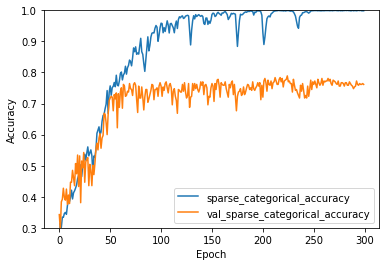

In [19]:
plt.plot(hist.history['accuracy'], label='sparse_categorical_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

In [12]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    input = Input((64, 64,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_0")(input)
    pool_0 = MaxPooling2D(pool_size=(2, 2), name='pool_0')(conv_0)

    conv_1 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_1")(pool_0)
    conv_2 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_2")(conv_1)
    output_1 = Add(name='add_1')([pool_0, conv_2])

    conv_3 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_3")(output_1)
    conv_4 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_4")(conv_3)
    output_2 = Add(name='add_2')([output_1, conv_4])

    conv_5 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_5")(output_2)
    conv_6 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_6")(conv_5)
    output_3 = Add(name='add_3')([output_2, conv_6])
    

    pooling = GlobalAveragePooling2D(name='globalAveragePooling2D')(output_3)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='relu', name='fully_connected')(flatten)
    dropout = Dropout(0.4, name='dropout')(fc_1)    
    output = Dense(32, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()

model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)


In [13]:
hist = model.fit(x_train, y_train , epochs=300,
                 batch_size=256,
                 validation_data=(x_test, y_test))



Train on 1456 samples, validate on 365 samples
Epoch 1/300
1456/1456 [==============================] - 2s 1ms/sample - loss: 49.1501 - accuracy: 0.1538 - val_loss: 4.5428 - val_accuracy: 0.3123
Epoch 2/300
1456/1456 [==============================] - 1s 651us/sample - loss: 12.6561 - accuracy: 0.2823 - val_loss: 3.8148 - val_accuracy: 0.3479
Epoch 3/300
1456/1456 [==============================] - 1s 630us/sample - loss: 7.1702 - accuracy: 0.3029 - val_loss: 2.3742 - val_accuracy: 0.3507
Epoch 4/300
1456/1456 [==============================] - 1s 636us/sample - loss: 4.8455 - accuracy: 0.3111 - val_loss: 1.5331 - val_accuracy: 0.3753
Epoch 5/300
1456/1456 [==============================] - 1s 634us/sample - loss: 3.3545 - accuracy: 0.3235 - val_loss: 1.3980 - val_accuracy: 0.4247
Epoch 6/300
1456/1456 [==============================] - 1s 639us/sample - loss: 2.5331 - accuracy: 0.3276 - val_loss: 1.3386 - val_accuracy: 0.4329
Epoch 7/300
1456/1456 [==============================] - 1s

1456/1456 [==============================] - 1s 636us/sample - loss: 1.1342 - accuracy: 0.5034 - val_loss: 1.1103 - val_accuracy: 0.4767
Epoch 56/300
1456/1456 [==============================] - 1s 629us/sample - loss: 1.1386 - accuracy: 0.4966 - val_loss: 1.1303 - val_accuracy: 0.4521
Epoch 57/300
1456/1456 [==============================] - 1s 627us/sample - loss: 1.1096 - accuracy: 0.5062 - val_loss: 1.1087 - val_accuracy: 0.5397
Epoch 58/300
1456/1456 [==============================] - 1s 632us/sample - loss: 1.1167 - accuracy: 0.5151 - val_loss: 1.1331 - val_accuracy: 0.4959
Epoch 59/300
1456/1456 [==============================] - 1s 629us/sample - loss: 1.1230 - accuracy: 0.5021 - val_loss: 1.1387 - val_accuracy: 0.4740
Epoch 60/300
1456/1456 [==============================] - 1s 629us/sample - loss: 1.1706 - accuracy: 0.4698 - val_loss: 1.1352 - val_accuracy: 0.4466
Epoch 61/300
1456/1456 [==============================] - 1s 649us/sample - loss: 1.1343 - accuracy: 0.4746 - val

1456/1456 [==============================] - 1s 631us/sample - loss: 0.8694 - accuracy: 0.6614 - val_loss: 0.9657 - val_accuracy: 0.6384
Epoch 110/300
1456/1456 [==============================] - 1s 633us/sample - loss: 0.8355 - accuracy: 0.6916 - val_loss: 0.9672 - val_accuracy: 0.6521
Epoch 111/300
1456/1456 [==============================] - 1s 631us/sample - loss: 0.8779 - accuracy: 0.6662 - val_loss: 1.8640 - val_accuracy: 0.4000
Epoch 112/300
1456/1456 [==============================] - 1s 629us/sample - loss: 1.4003 - accuracy: 0.4183 - val_loss: 1.2110 - val_accuracy: 0.4603
Epoch 113/300
1456/1456 [==============================] - 1s 631us/sample - loss: 1.2910 - accuracy: 0.4073 - val_loss: 1.1718 - val_accuracy: 0.4466
Epoch 114/300
1456/1456 [==============================] - 1s 636us/sample - loss: 1.2110 - accuracy: 0.4210 - val_loss: 1.1492 - val_accuracy: 0.4548
Epoch 115/300
1456/1456 [==============================] - 1s 637us/sample - loss: 1.1639 - accuracy: 0.4650

1456/1456 [==============================] - 1s 633us/sample - loss: 0.5030 - accuracy: 0.8310 - val_loss: 0.9275 - val_accuracy: 0.7288
Epoch 164/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.5022 - accuracy: 0.8242 - val_loss: 0.8332 - val_accuracy: 0.6932
Epoch 165/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.4740 - accuracy: 0.8290 - val_loss: 0.8077 - val_accuracy: 0.7288
Epoch 166/300
1456/1456 [==============================] - 1s 634us/sample - loss: 0.4532 - accuracy: 0.8352 - val_loss: 0.8397 - val_accuracy: 0.7123
Epoch 167/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.4614 - accuracy: 0.8386 - val_loss: 0.8572 - val_accuracy: 0.7315
Epoch 168/300
1456/1456 [==============================] - 1s 633us/sample - loss: 0.4481 - accuracy: 0.8475 - val_loss: 0.8137 - val_accuracy: 0.7178
Epoch 169/300
1456/1456 [==============================] - 1s 632us/sample - loss: 0.4314 - accuracy: 0.8516

1456/1456 [==============================] - 1s 640us/sample - loss: 0.3132 - accuracy: 0.8922 - val_loss: 1.1468 - val_accuracy: 0.6877
Epoch 218/300
1456/1456 [==============================] - 1s 637us/sample - loss: 0.3245 - accuracy: 0.8812 - val_loss: 0.8990 - val_accuracy: 0.7233
Epoch 219/300
1456/1456 [==============================] - 1s 634us/sample - loss: 0.2707 - accuracy: 0.9066 - val_loss: 1.0396 - val_accuracy: 0.7397
Epoch 220/300
1456/1456 [==============================] - 1s 631us/sample - loss: 0.2327 - accuracy: 0.9217 - val_loss: 1.1172 - val_accuracy: 0.7233
Epoch 221/300
1456/1456 [==============================] - 1s 634us/sample - loss: 0.2184 - accuracy: 0.9272 - val_loss: 1.2787 - val_accuracy: 0.7178
Epoch 222/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.1927 - accuracy: 0.9375 - val_loss: 1.2994 - val_accuracy: 0.7233
Epoch 223/300
1456/1456 [==============================] - 1s 632us/sample - loss: 0.1796 - accuracy: 0.9478

1456/1456 [==============================] - 1s 630us/sample - loss: 0.0804 - accuracy: 0.9821 - val_loss: 1.6818 - val_accuracy: 0.7507
Epoch 272/300
1456/1456 [==============================] - 1s 638us/sample - loss: 0.1066 - accuracy: 0.9684 - val_loss: 2.1072 - val_accuracy: 0.6740
Epoch 273/300
1456/1456 [==============================] - 1s 638us/sample - loss: 0.0908 - accuracy: 0.9657 - val_loss: 2.0431 - val_accuracy: 0.6986
Epoch 274/300
1456/1456 [==============================] - 1s 643us/sample - loss: 0.0888 - accuracy: 0.9691 - val_loss: 2.0911 - val_accuracy: 0.7041
Epoch 275/300
1456/1456 [==============================] - 1s 639us/sample - loss: 0.0729 - accuracy: 0.9766 - val_loss: 2.1236 - val_accuracy: 0.7096
Epoch 276/300
1456/1456 [==============================] - 1s 632us/sample - loss: 0.0896 - accuracy: 0.9718 - val_loss: 2.3211 - val_accuracy: 0.7205
Epoch 277/300
1456/1456 [==============================] - 1s 631us/sample - loss: 0.0871 - accuracy: 0.9760

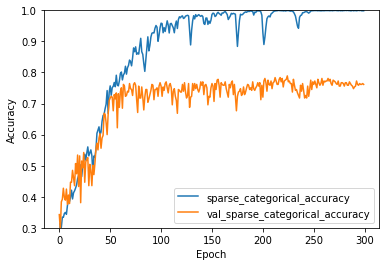

In [21]:
plt.plot(hist.history['accuracy'], label='sparse_categorical_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

In [14]:
from tensorflow.keras.layers import Input, Add, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop

def resnet_model():
    
    input = Input((64, 64,3), name="input")

    conv_0 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_0")(input)
    pool_0 = MaxPooling2D(pool_size=(2, 2), name='pool_0')(conv_0)

    conv_1 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_1")(pool_0)
    conv_2 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_2")(conv_1)
    output_1 = Add(name='add_1')([pool_0, conv_2])

    conv_3 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_3")(output_1)
    conv_4 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_4")(conv_3)
    output_2 = Add(name='add_2')([output_1, conv_4])

    conv_5 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_5")(output_2)
    conv_6 = Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='SAME', name="conv_6")(conv_5)
    output_3 = Add(name='add_3')([output_2, conv_6])
    

    pooling = GlobalAveragePooling2D(name='globalAveragePooling2D')(output_3)

    flatten = Flatten(name="flatten")(pooling)
    fc_1 = Dense(128, activation='relu', name='fully_connected')(flatten)
    dropout = Dropout(0.4, name='dropout')(fc_1)    
    output = Dense(64, activation='softmax', name='output')(dropout)
    model = Model(input, output)
    
    return model
    
model = resnet_model()

model.compile(
  optimizer=Adam(learning_rate=0.001),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

hist = model.fit(x_train, y_train , epochs=300,
                 batch_size=256,
                 validation_data=(x_test, y_test))


Train on 1456 samples, validate on 365 samples
Epoch 1/300
1456/1456 [==============================] - 1s 1ms/sample - loss: 50.7656 - accuracy: 0.1374 - val_loss: 7.8519 - val_accuracy: 0.3233
Epoch 2/300
1456/1456 [==============================] - 1s 641us/sample - loss: 12.5365 - accuracy: 0.2816 - val_loss: 3.4081 - val_accuracy: 0.3452
Epoch 3/300
1456/1456 [==============================] - 1s 646us/sample - loss: 7.3109 - accuracy: 0.3146 - val_loss: 2.8842 - val_accuracy: 0.3342
Epoch 4/300
1456/1456 [==============================] - 1s 648us/sample - loss: 5.1148 - accuracy: 0.3070 - val_loss: 1.9092 - val_accuracy: 0.2521
Epoch 5/300
1456/1456 [==============================] - 1s 647us/sample - loss: 3.2726 - accuracy: 0.3276 - val_loss: 1.5424 - val_accuracy: 0.4027
Epoch 6/300
1456/1456 [==============================] - 1s 648us/sample - loss: 2.5402 - accuracy: 0.2891 - val_loss: 1.3214 - val_accuracy: 0.4027
Epoch 7/300
1456/1456 [==============================] - 1s

1456/1456 [==============================] - 1s 638us/sample - loss: 1.1365 - accuracy: 0.5048 - val_loss: 1.1325 - val_accuracy: 0.4767
Epoch 56/300
1456/1456 [==============================] - 1s 633us/sample - loss: 1.1507 - accuracy: 0.5055 - val_loss: 1.0989 - val_accuracy: 0.5370
Epoch 57/300
1456/1456 [==============================] - 1s 633us/sample - loss: 1.1700 - accuracy: 0.4766 - val_loss: 1.1560 - val_accuracy: 0.4438
Epoch 58/300
1456/1456 [==============================] - 1s 631us/sample - loss: 1.1773 - accuracy: 0.4691 - val_loss: 1.1473 - val_accuracy: 0.4630
Epoch 59/300
1456/1456 [==============================] - 1s 635us/sample - loss: 1.1601 - accuracy: 0.4828 - val_loss: 1.1202 - val_accuracy: 0.5068
Epoch 60/300
1456/1456 [==============================] - 1s 635us/sample - loss: 1.1455 - accuracy: 0.5014 - val_loss: 1.1130 - val_accuracy: 0.5233
Epoch 61/300
1456/1456 [==============================] - 1s 634us/sample - loss: 1.1304 - accuracy: 0.5158 - val

1456/1456 [==============================] - 1s 636us/sample - loss: 1.0397 - accuracy: 0.5625 - val_loss: 1.0709 - val_accuracy: 0.5479
Epoch 110/300
1456/1456 [==============================] - 1s 636us/sample - loss: 1.0171 - accuracy: 0.5790 - val_loss: 1.1380 - val_accuracy: 0.5041
Epoch 111/300
1456/1456 [==============================] - 1s 634us/sample - loss: 1.0209 - accuracy: 0.5776 - val_loss: 1.1373 - val_accuracy: 0.5315
Epoch 112/300
1456/1456 [==============================] - 1s 631us/sample - loss: 1.0336 - accuracy: 0.5604 - val_loss: 1.0734 - val_accuracy: 0.5479
Epoch 113/300
1456/1456 [==============================] - 1s 636us/sample - loss: 0.9905 - accuracy: 0.6016 - val_loss: 1.0968 - val_accuracy: 0.5260
Epoch 114/300
1456/1456 [==============================] - 1s 636us/sample - loss: 0.9909 - accuracy: 0.5790 - val_loss: 1.0692 - val_accuracy: 0.5534
Epoch 115/300
1456/1456 [==============================] - 1s 637us/sample - loss: 1.0122 - accuracy: 0.5831

1456/1456 [==============================] - 1s 634us/sample - loss: 0.4723 - accuracy: 0.8262 - val_loss: 0.8185 - val_accuracy: 0.7452
Epoch 164/300
1456/1456 [==============================] - 1s 642us/sample - loss: 0.5049 - accuracy: 0.8276 - val_loss: 0.7867 - val_accuracy: 0.7397
Epoch 165/300
1456/1456 [==============================] - 1s 640us/sample - loss: 0.4708 - accuracy: 0.8276 - val_loss: 0.7985 - val_accuracy: 0.7507
Epoch 166/300
1456/1456 [==============================] - 1s 633us/sample - loss: 0.4510 - accuracy: 0.8427 - val_loss: 0.8491 - val_accuracy: 0.7425
Epoch 167/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.4556 - accuracy: 0.8352 - val_loss: 0.9463 - val_accuracy: 0.6877
Epoch 168/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.4388 - accuracy: 0.8468 - val_loss: 0.8057 - val_accuracy: 0.7370
Epoch 169/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.4135 - accuracy: 0.8578

1456/1456 [==============================] - 1s 638us/sample - loss: 0.2141 - accuracy: 0.9354 - val_loss: 1.2522 - val_accuracy: 0.7753
Epoch 218/300
1456/1456 [==============================] - 1s 637us/sample - loss: 0.2102 - accuracy: 0.9251 - val_loss: 1.3626 - val_accuracy: 0.7534
Epoch 219/300
1456/1456 [==============================] - 1s 640us/sample - loss: 0.2208 - accuracy: 0.9224 - val_loss: 1.1560 - val_accuracy: 0.7315
Epoch 220/300
1456/1456 [==============================] - 1s 639us/sample - loss: 0.1718 - accuracy: 0.9437 - val_loss: 1.2486 - val_accuracy: 0.7562
Epoch 221/300
1456/1456 [==============================] - 1s 636us/sample - loss: 0.2118 - accuracy: 0.9210 - val_loss: 1.4850 - val_accuracy: 0.7260
Epoch 222/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.2951 - accuracy: 0.8984 - val_loss: 1.1422 - val_accuracy: 0.7096
Epoch 223/300
1456/1456 [==============================] - 1s 632us/sample - loss: 0.3918 - accuracy: 0.8544

1456/1456 [==============================] - 1s 632us/sample - loss: 0.5183 - accuracy: 0.8104 - val_loss: 0.7794 - val_accuracy: 0.7726
Epoch 272/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.5014 - accuracy: 0.8049 - val_loss: 0.9214 - val_accuracy: 0.7397
Epoch 273/300
1456/1456 [==============================] - 1s 634us/sample - loss: 0.4789 - accuracy: 0.8214 - val_loss: 0.9644 - val_accuracy: 0.7644
Epoch 274/300
1456/1456 [==============================] - 1s 640us/sample - loss: 0.4905 - accuracy: 0.8139 - val_loss: 0.8965 - val_accuracy: 0.7562
Epoch 275/300
1456/1456 [==============================] - 1s 632us/sample - loss: 0.4922 - accuracy: 0.8077 - val_loss: 0.8265 - val_accuracy: 0.7370
Epoch 276/300
1456/1456 [==============================] - 1s 634us/sample - loss: 0.4542 - accuracy: 0.8187 - val_loss: 1.0125 - val_accuracy: 0.7288
Epoch 277/300
1456/1456 [==============================] - 1s 635us/sample - loss: 0.4498 - accuracy: 0.8262

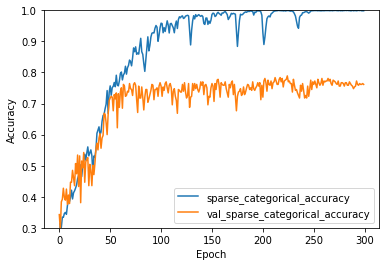

In [22]:
plt.plot(hist.history['accuracy'], label='sparse_categorical_accuracy')
plt.plot(hist.history['val_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')